# Model selection experiment

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def generate_toy_data(n_samples=15, show=False, sigma=0.25, type="sin", w=None):
    if type == "sin":
        noise = np.random.randn(n_samples) * sigma # gaussian noise
        x = np.random.uniform(0, 2 * np.pi, n_samples) # x uniformly distributed in [0, 2pi]
        y = np.sin(x) + noise # y = sin(x) + noise
    elif type == "gaussian":
        if w is None:
            w = np.random.randn(50)
            w = w / np.linalg.norm(w) / 2
        noise = np.random.randn(n_samples) * sigma
        d = w.shape[0]
        x = np.random.randn(n_samples, d)
        noise = np.random.randn(n_samples) * sigma
        y = x @ w + noise
        
        
    if show:
        if type == "sin":
            plt.scatter(x, y, s=3, c='black')
            plt.xlim(0, 2 * np.pi + 0.75)
            plt.ylim(-2, 1.5)
            # x axis ticks to 2 pi  multiple of 1/2 pi
            plt.xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
        elif type == "gaussian":
            plt.scatter(x[:, 0], y, s=3, c='black')
            plt.xlim(-3, 3)
            plt.ylim(-3, 3)
     
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Toy data with sigma = {sigma} and n_samples = {n_samples}")
        plt.grid()
        plt.show()        
    return x, y

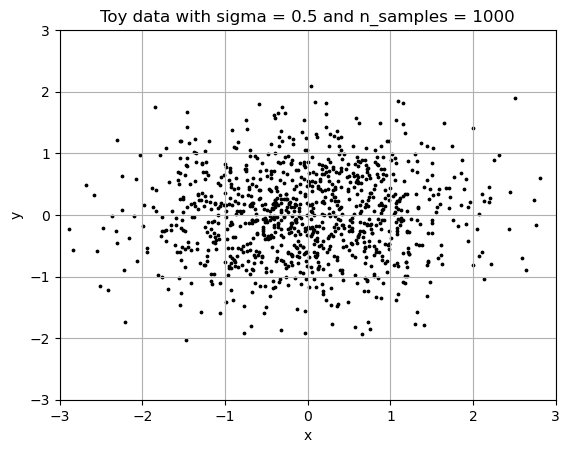

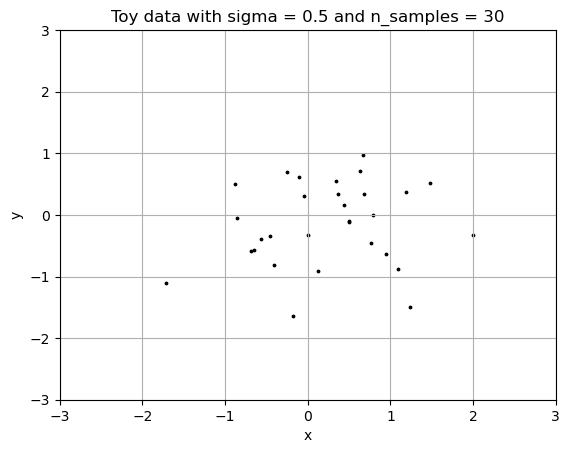

In [433]:
x_test, y_test = generate_toy_data(show=True, n_samples=1000, sigma=np.sqrt(0.25), type="gaussian")
x, y = generate_toy_data(show=True, n_samples=30, sigma=np.sqrt(0.25), type="gaussian")

In [41]:
sigma_pi_sq = 1/0.005
sigma_sq = 0.5

L = 7


phi = lambda x, d: np.array([x**i for i in range(d+1)]).T

def KL_divergence(d, A, A_inv, w_hat):
    kl = 0.5 * ((1/sigma_pi_sq) * (np.trace(A_inv) + w_hat.T @ w_hat) - (d+1) + np.log(np.linalg.det(A)) + (d+1) * np.log(sigma_pi_sq))

    return kl

def empirical_risk(y, w, phi_x):
    return  0.5 * ((1/sigma_sq) * np.mean((y - phi_x @ w)**2) + np.log(2 * np.pi * sigma_sq))

def empirical_loss(n, y, w_hat, phi_x, A_inv):
    return n * empirical_risk(y, w_hat, phi_x) + 0.5 * (1/sigma_sq) * np.trace(phi_x.T @ phi_x @ A_inv)



def fit_poly(x, y, d):
    p = np.polyfit(x, y, d)
    y_hat = np.polyval(p, x)
    return p, y_hat


def plot_poly(p, ax):
    d = len(p) - 1
    x = np.linspace(0, 2 * np.pi, 100)
    y = np.polyval(p, x)
    ax.plot(x, y, label=f"model d={d}")
    return ax

def get_losses(x, y, d, n):
    phi_x = phi(x, d)
    A = (1/sigma_sq) * phi_x.T @ phi_x + (1/sigma_pi_sq) * np.eye(d+1)
    A_inv = np.linalg.inv(A)
    w_hat = (1/sigma_sq) * A_inv @ phi_x.T @ y
    return empirical_loss(n, y, w_hat, phi_x, A_inv), KL_divergence(d, A, A_inv, w_hat)

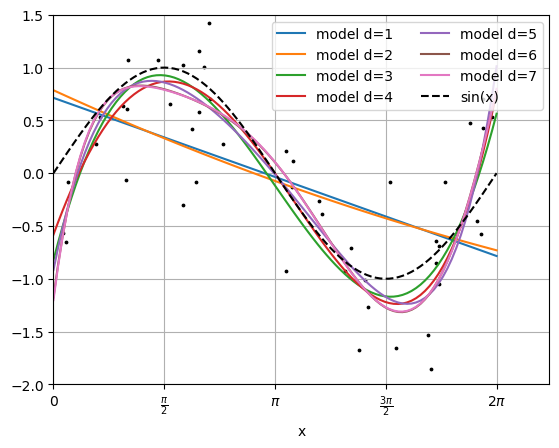

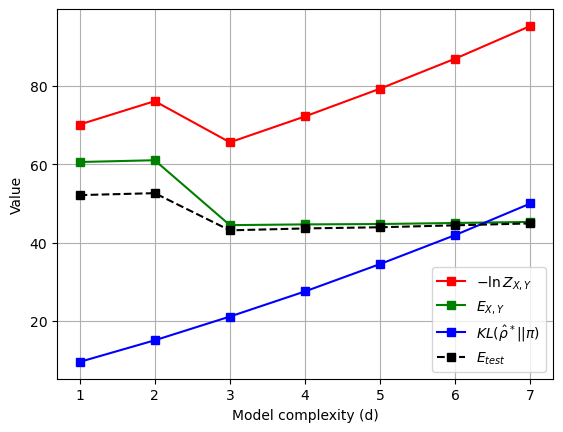

In [312]:
fig, ax = plt.subplots()
n = 50
n_test = 1000
s = np.sqrt(0.25) 
# s = 0.25
x, y = generate_toy_data(show=False, n_samples=n, sigma=s)
x_test, y_test = generate_toy_data(show=False, n_samples=n_test, sigma=s)
nmlls = []
losses = []
test_losses = []
kls = []

for d in range(1, L+1):
    p, y_hat = fit_poly(x, y, d)
    ax = plot_poly(p, ax)

    empirical_loss_, kl = get_losses(x, y, d, n)

    test_loss_, _ = get_losses(x_test, y_test, d, n)

    nmlls.append(empirical_loss_ + kl)
    losses.append(empirical_loss_)
    kls.append(kl)
    test_losses.append(test_loss_)

ax.scatter(x, y, color="black", s=3)
x_ = np.linspace(0, 2 * np.pi, 100) 
ax.plot(x_, np.sin(x_), label="sin(x)", color="black", linestyle="--")
ax.set_xlim(0, 2 * np.pi + 0.75)
ax.set_ylim(-2, 1.5)
# change the names of x axis ticks to 2 pi  multiple of 1/2 pi
ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi], ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax.set_xlabel("x")
# put the legend on top right corner with two columns
ax.legend(loc="upper right", ncol=2)
ax.grid()
plt.show()


# plot the negative marginal log likelihood, loss and kl
fig, ax = plt.subplots()
ax.plot(range(1, L+1), nmlls, label=r"$-\ln Z_{X,Y}$", marker="s", color="r")
ax.plot(range(1, L+1), losses, label=r"$n E_{X,Y}$", marker="s", color="g")
ax.plot(range(1, L+1), kls, label=r"$KL(\hat{\rho}^* || \pi)$", marker="s", color="b")
ax.plot(range(1, L+1), test_losses, label=r"$n E_{test}$", marker="s", linestyle="--", color="black")
ax.set_xlabel("Model complexity (d)")
ax.set_ylabel("Value")
ax.legend()
ax.grid()

Number of samples in train: 213
Number of samples in test: 854


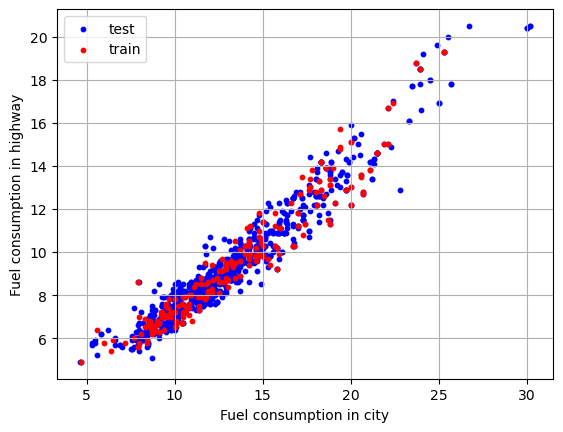

In [78]:
# load fuel consumption dataset
import pandas as pd
data = pd.read_csv("FuelConsumption.csv")

# extract test and train data for the two features
x = data.FUELCONSUMPTION_CITY.values
y = data.FUELCONSUMPTION_HWY.values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=123)


# num_samples in test and train
n = len(x_train)
n_test = len(x_test)
print(f"Number of samples in train: {n}")
print(f"Number of samples in test: {n_test}")

# plot the train in red and test data in blue
fig, ax = plt.subplots()
ax.scatter(x_test, y_test, s=10, c="blue", label="test")
ax.scatter(x_train, y_train, s=10, c="red", label="train")
ax.set_xlabel("Fuel consumption in city")
ax.set_ylabel("Fuel consumption in highway")
ax.legend()
ax.grid()
plt.show()

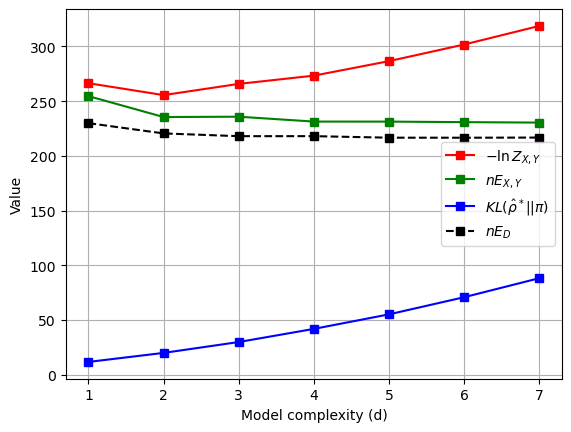

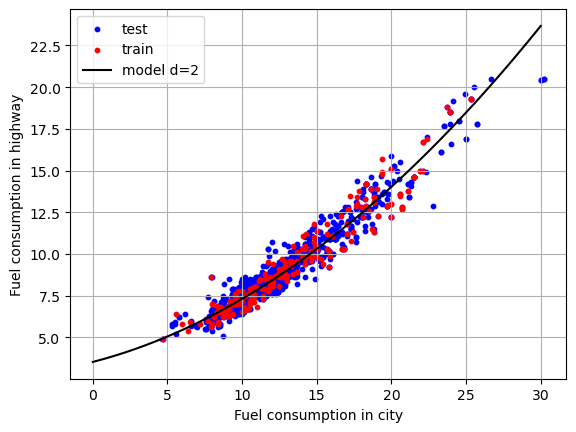

In [79]:
# model selection using marginal likelihood
L = 7
nmlls = []
losses = []
test_losses = []
kls = []

for d in range(1, L+1):
    p, y_hat = fit_poly(x_train, y_train, d)
    empirical_loss_, kl = get_losses(x_train, y_train, d, n)
    test_loss_, _ = get_losses(x_test, y_test, d, n)
    nmlls.append(empirical_loss_ + kl)
    losses.append(empirical_loss_)
    kls.append(kl)
    test_losses.append(test_loss_)

# plot the negative marginal log likelihood, loss and kl
fig, ax = plt.subplots()
ax.plot(range(1, L+1), nmlls, label=r"$-\ln Z_{X,Y}$", marker="s", color="r")
ax.plot(range(1, L+1), losses, label=r"$n E_{X,Y}$", marker="s", color="g")
ax.plot(range(1, L+1), kls, label=r"$KL(\hat{\rho}^* || \pi)$", marker="s", color="b")
ax.plot(range(1, L+1), test_losses, label=r"$n E_{D}$", marker="s", linestyle="--", color="black")
ax.set_xlabel("Model complexity (d)")
ax.set_ylabel("Value")
ax.legend()
ax.grid()
plt.show()

# plot the best model that minimizes the nllm
d = np.argmin(nmlls) + 1
fig, ax = plt.subplots()
p, y_hat = fit_poly(x_train, y_train, d)
ax.scatter(x_test, y_test, s=10, c="blue", label="test")
ax.scatter(x_train, y_train, s=10, c="red", label="train")
ax.set_xlabel("Fuel consumption in city")
ax.set_ylabel("Fuel consumption in highway")
x_ = np.linspace(0, 30, 100)
y_ = np.polyval(p, x_)
ax.plot(x_, y_, label=f"model d={d}", color="black")
ax.legend()
ax.grid()
plt.show()


## Empirical comparison of bound values

In [437]:

sigma_pi_sq = 1/100
sigma_noise_sq = 1/9
sigma_sq = 2
d = 50
w_star = np.random.randn(d)
w_star = w_star / np.linalg.norm(w_star) / 2
# training_samples_sizes are multipses of 10 from 10 to 10^6
# generate 10^8 samples for train
x, y = generate_toy_data(n_samples=10**8, show=False, sigma=np.sqrt(sigma_noise_sq), type="gaussian", w=w_star)
x_test, y_test = generate_toy_data(n_samples=10**8, show=False, sigma=np.sqrt(sigma_noise_sq), type="gaussian", w=w_star)
empirical_nll_losses = []
test_losses = []
# select n with 20 values from 10 to 10^6
nub_samples = np.logspace(1, 6, 20, base=10)
for n in nub_samples:
    # randomly pick n samples from the generated data
    idx = np.random.choice(10**6, int(n))
    x = x[idx]
    y = y[idx]
    A = (1/sigma_sq) * x.T @ x + (1/sigma_pi_sq) * np.eye(d)
    A_inv = np.linalg.inv(A)
    w_hat = (1/sigma_sq) * A_inv @ x.T @ y
    empirical_nll_loss = empirical_risk(y, w_hat, x)
    empirical_nll_losses.append(empirical_nll_loss)
    phi_x_test = x_test
    test_loss = empirical_risk(y_test, w_hat, x_test)
    test_losses.append(test_loss)


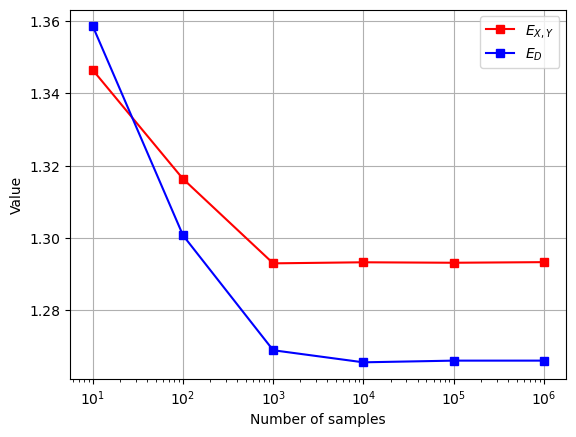

In [436]:
fig, ax = plt.subplots()
ax.plot(nub_samples, empirical_nll_losses, label=r"$E_{X,Y}$", marker="s", color="r")
ax.plot(nub_samples, test_losses, label=r"$E_{D}$", marker="s", color="b")
# set the x axis to 10^i for i in range(1, 6+1)
ax.set_xscale("log")
ax.set_xticks([10**i for i in range(1, 6+1)])

ax.set_xlabel("Number of samples")
ax.set_ylabel("Value")
ax.legend()
ax.grid()
plt.show()

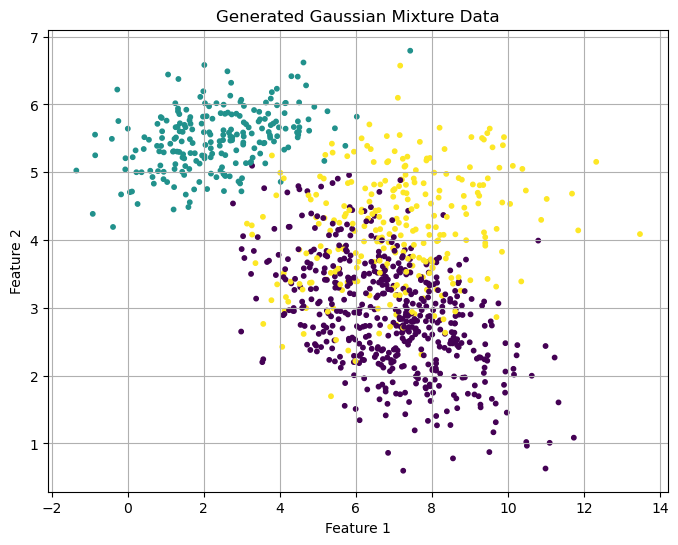

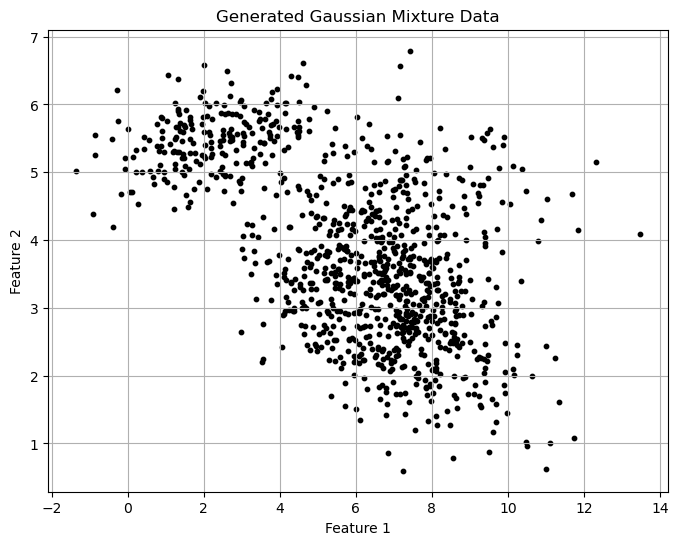

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix

# generate gaussian mixture data
def generate_gaussian_mixture(n_samples, n_features, n_components, 
                              mean=None, covariance=None, weights=None, 
                              random_state=None, show=False, show_labels=False):
    np.random.seed(random_state)

    if mean is None:
        means = []
        for _ in range(n_components):
            mean = np.random.rand(n_features) * 10
            means.append(mean)

    if covariance is None:
        covariances = []
        for _ in range(n_components):
            covariance = make_spd_matrix(n_features)
            covariances.append(covariance)

    if weights is None:
        weights = np.random.rand(n_components)
        weights /= np.sum(weights)

    data = []
    labels = []
    for _ in range(n_samples):
        component = np.random.choice(n_components, p=weights)
        sample = np.random.multivariate_normal(means[component], covariances[component])
        data.append(sample)
        labels.append(component)
    data, labels = np.array(data), np.array(labels)

    if show:
        # Visualize the data
        plt.figure(figsize=(8, 6))
        if show_labels:
            plt.scatter(data[:, 0], data[:, 1], s=10, c=labels, cmap='viridis')
        else:
            plt.scatter(data[:, 0], data[:, 1], s=10, c='black')
        plt.title('Generated Gaussian Mixture Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.grid(True)
        plt.show()

    return data, labels

# Generate Gaussian mixture data
n_samples = 1000
n_features = 2
n_components = 3
data, labels = generate_gaussian_mixture(n_samples, n_features, n_components, random_state=123, show=True, show_labels=True)

data, labels = generate_gaussian_mixture(n_samples, n_features, n_components, random_state=123, show=True, show_labels=False)



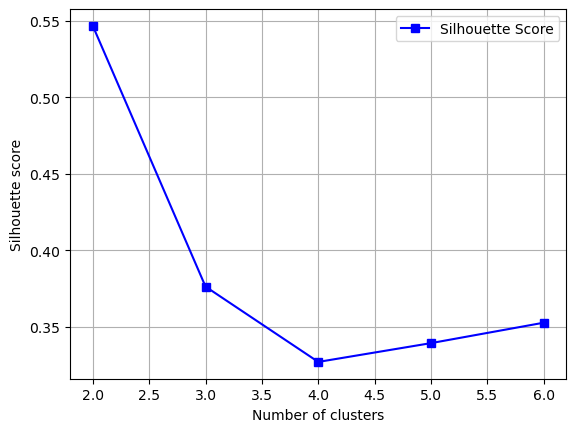

In [9]:
n_clusters = [2, 3, 4, 5, 6]

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

silhouette_scores_kmeans = []
silhouette_scores_gmm = []

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=123)
    gmm.fit(data)
    labels = gmm.predict(data)
    silhouette_scores_gmm.append(silhouette_score(data, labels))

fig, ax = plt.subplots()
ax.plot(n_clusters, silhouette_scores_gmm, label="Silhouette Score", marker="s", color="b")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.legend()
ax.grid()
plt.show()


In [15]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

# Example dataset X and fitting a GMM to it
gmm = GaussianMixture(n_components=3)
gmm.fit(data)

# Extracting parameters from the trained GMM
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

# Compute log-likelihood using the provided function
def compute_gmm_log_likelihood(data, means, covariances, weights):
    n_samples, _ = data.shape
    n_components = len(weights)
    log_likelihood = 0.0

    for i in range(n_samples):
        likelihood_i = 0.0
        for k in range(n_components):
            likelihood_i += weights[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
        log_likelihood += np.log(likelihood_i)

    return log_likelihood

log_likelihood = compute_gmm_log_likelihood(data, means, covariances, weights)
print("Negative Log-Likelihood:", - log_likelihood)

Negative Log-Likelihood: 3607.622194573552
